# Figure 4, Event-dependent scaling factor and temporal noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

import a.lib.dataloader as dl
from a.lib.tools import mse, dist, lpf, converged, combinations

In [2]:
# Set figure aesthetics
sns.set_context("notebook")
sns.set_style("ticks")

## LIF

### Fraction converged

In [3]:
# Extract fraction of converged simulations for all parameter combinations
keys = ["w", "$\\tau_s$", "$\\tau_m$", "$V_R$"]

all_vals = []
for k in range(3):
    xticks = []
    vals = []
    for n, comb in enumerate(combinations(4, False)):
        prefix = "".join(["1" if x else "0" for x in comb])
        data = dl.DataLoader("./a/results/", "mode_" + str(k) + "_" + prefix).merge()
        if data == {}:
            print("Data empty")
            break
        seeds = data["ws"].shape[0]
        converged_n = 0
        not_converged = []
        did_converged = []
        for i in range(seeds):
            if data["tau_s_target"][i] == 0.:
                seeds -= 1
                continue
            datas = [data[key][i].T for key in ["ws", "tau_s", "tau_m", "v_reset"]]
            targets = [data[key][i] for key in ["ws_target", "tau_s_target", "tau_m_target", "v_reset_target"]]
            convs = converged(datas, targets, [0.1, 0.025, 0.025, 0.1])
            if np.any(convs[-50:] < 1):
                continue
            else:
                converged_n += 1
        vals.append((converged_n / seeds) * 100)
        xticks.append(", ".join([keys[i] for i, k in enumerate(prefix) if k == "1"]))
    all_vals.append(vals)

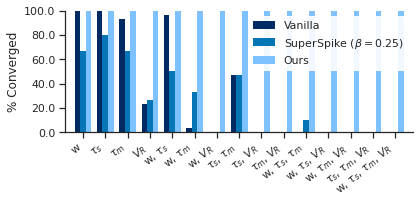

In [4]:
# Plot
colors = sns.color_palette(['#002a61', '#0675b6', '#7dc2ff'])

fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(6, 3.))
for k in range(3):
    if k == 0:
        label = "Vanilla"
    elif k == 1:
        label = "SuperSpike ($\\beta=0.25$)"
    elif k == 2:
        label = "Ours"
    ax.bar(np.arange(len(all_vals[k]))+(k-1)*0.25, all_vals[k], color=colors[k], width=0.25, linewidth=0., label=label)
ax.legend(shadow=False, edgecolor="w", framealpha=0.9)
ax.set_xticks(range(len(vals)))
ax.set_xticklabels(xticks, rotation=40, ha="right")
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
sns.despine()

ax.set_xlim(-.8, 14.8)
ax.set_ylim(0., 100.)
ax.set_ylabel("% Converged")
fig.tight_layout()

fig.savefig("figure-4-a.svg", pad_inches=0.)

### Surrogate gradient different beta values

In [5]:
# Fraction converged for multiple beta values
lr = "0.000100"
datas = []
betas = ["0.015625", "0.031250", "0.062500", "0.125000", "0.250000", "0.500000", "1.000000", "2.000000", "4.000000"]
for n, beta in enumerate(betas):
    vals = []
    data = dl.DataLoader("./b/results/", "mode_" + str(lr) + "_"  + str(beta) + "_1000").merge()
    if data == {}:
        print("Data empty")
        break
    datas.append(data)

vals = []
for data in datas:
    converged_n = 0
    for i in range(seeds):
        if data["tau_s_target"][i] == 0.:
            seeds -= 1
            continue
        all_datas = [data[key][i].T for key in ["ws", "tau_s", "tau_m", "v_reset"]]
        targets = [data[key][i] for key in ["ws_target", "tau_s_target", "tau_m_target", "v_reset_target"]]
        convs = converged(all_datas, targets, [0.1, 0.025, 0.025, 0.1])
        if np.any(convs[-25:] < 1):
            continue
        else:
            converged_n += 1
    vals.append((converged_n / seeds) * 100)

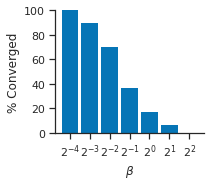

In [6]:
# Plot
sns.set_palette(sns.color_palette(['#0675b6']))
fig, ax = plt.subplots(figsize=(3.1, 2.7))
ax.bar(range(len(vals)-2), vals[2:], width=0.85, linewidth=0.)
ax.set_xticks(range(len(vals)-2))
ax.set_xticklabels(["$2^{" + str(n) +"}$" for n in range(-4, 3)])
ax.set_xlabel("$\\beta$")
ax.set_ylabel("% Converged")
sns.despine()
fig.tight_layout()
ax.set_ylim(0., 100.)
fig.savefig("figure-4-b.svg", pad_inches=0.)

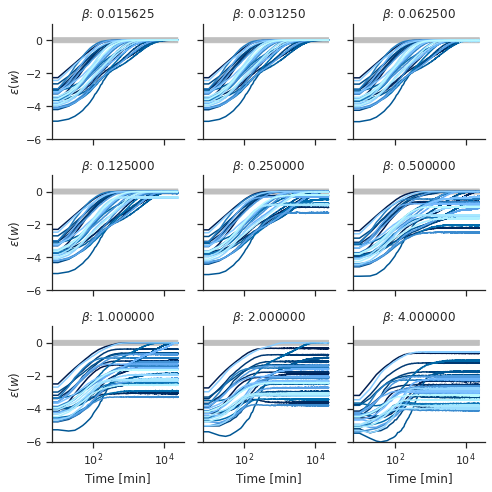

In [7]:
# Plot full training trajectories
sns.set_palette(['#001649', '#001d50', '#002359', '#002a61', '#00316a', '#003872', '#00407a',
                 '#004783', '#004f8b', '#005694', '#005e9d', '#0066a5', '#006dae', '#0e75b7',
                 '#227cbf', '#3084c7', '#3b8bcf', '#4593d7', '#4f9adf', '#59a2e8', '#62aaf0',
                 '#6bb2f9', '#74bafe', '#7ec3ff', '#88ccff', '#91d5ff', '#9bdeff', '#a5e7ff',
                 '#aef0ff', '#b7f9ff'])

lr = "0.000100"
x = np.linspace(0, datas[0]["ws"][0].shape[1]*10, datas[0]["ws"][0].shape[1])

fig, axs = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=True)
axs = axs.flatten()
for n, data in enumerate(datas):
    for i in range(seeds):
        axs[n].semilogx(x, dist(data["ws"][i].T, data["ws_target"][i]))
    axs[n].fill_between(x, 0.15, -0.15, color=[0.75, 0.75, 0.75])
    axs[n].set_title("$\\beta$: " + betas[n])
    axs[n].set_ylim(-6, 1)
    if n > 5:
        axs[n].set_xlabel("Time [min]")
    if n % 3 == 0:
        axs[n].set_ylabel("$\\epsilon(w)$")
sns.despine()
fig.tight_layout()

## LRF

### Fraction converged

In [8]:
# Extract fraction of converged simulations for all parameter combinations
keys = ["w", "b", "$\omega$", "$\\tilde{V}_R$", "$\\tilde{I}_R$"]

all_vals = []
for k in range(3):
    if k == 0:
        xticks = []
    vals = []
    for n, comb in enumerate(combinations(5, False)):
        seeds = 30
        prefix = "".join(["1" if x else "0" for x in comb])
        data = dl.DataLoader("./c/results/", "mode_" + str(k) + "_" + prefix).merge()
        if data == {}:
            print("Data empty")
            break
        seeds = data["ws"].shape[0]
        converged_n = 0
        not_converged = []
        did_converged = []
        for i in range(seeds):
            if data["b_target"][i] == 0.:
                seeds -= 1
                continue
            all_datas = [data[key][i].T for key in ["ws", "b", "omega", "v_reset", "i_reset"]]
            targets = [data[key][i] for key in ["ws_target", "b_target", "omega_target", "v_reset_target", "i_reset_target"]]
            convs = converged(all_datas, targets, [0.05, 0.025, 0.025, 0.1, 0.1])
            if np.any(convs[-50:] < 1):
                continue
            else:
                converged_n += 1
        vals.append((converged_n / seeds) * 100)
        xticks.append(", ".join([keys[i] for i, k in enumerate(prefix) if k == "1"]))
    all_vals.append(vals)

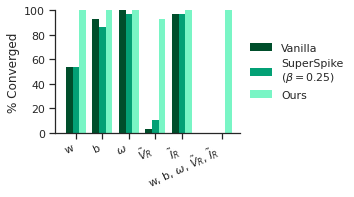

In [9]:
# Plot
colors = sns.color_palette(['#004e2b', '#03a075', '#79f5c5'])

fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(3.5, 2.25))
for k in range(3):
    if k == 0:
        label = "Vanilla"
    elif k == 1:
        label = "SuperSpike\n($\\beta=0.25$)"
    elif k == 2:
        label = "Ours"
    ax.bar(np.arange(5)+(k-1)*0.25, all_vals[k][:5], color=colors[k], width=0.25, linewidth=0., label=label)
    ax.bar(5.5+(k-1)*0.25, all_vals[k][-1], color=colors[k], width=0.25, linewidth=0.)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.95, box.height])
    
ax.legend(shadow=False, edgecolor="w", framealpha=0.9, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(list(range(5)) + [5.5])
ax.set_xticklabels(xticks[:5] + [xticks[30]], rotation=25, ha="right")
sns.despine()

ax.set_xlim(-.8, 6.2)
ax.set_ylim(0., 100.)
ax.set_ylabel("% Converged")
#fig.tight_layout()

fig.savefig("figure-4-c.svg", pad_inches=0.)

### Surrogate gradient different beta values

In [10]:
# Fraction converged for multiple beta values
lr = "0.000100"
datas = []
betas = ["0.015625", "0.031250", "0.062500", "0.125000", "0.250000", "0.500000", "1.000000", "2.000000", "4.000000"]
for n, beta in enumerate(betas):
    vals = []
    data = dl.DataLoader("./d/results/", "mode_" + str(lr) + "_"  + str(beta) + "_1000").merge()
    if data == {}:
        print("Data empty")
        break
    datas.append(data)


vals = []
for data in datas:
    seeds = 30
    converged_n = 0
    for i in range(seeds):
        if data["b_target"][i] == 0.:
            seeds -= 1
            continue
        all_datas = [data[key][i].T for key in ["ws", "b", "omega", "v_reset", "i_reset"]]
        targets = [data[key][i] for key in ["ws_target", "b_target", "omega_target", "v_reset_target", "i_reset_target"]]
        convs = converged(all_datas, targets, [0.05, 0.025, 0.025, 0.1, 0.1])
        if np.any(convs[-25:] < 1):
            continue
        else:
            converged_n += 1
    vals.append((converged_n / seeds) * 100)

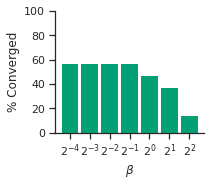

In [11]:
# Plot
sns.set_palette(sns.color_palette(['#03a075']))
fig, ax = plt.subplots(figsize=(3.1, 2.75))
ax.bar(range(len(vals)-2), vals[2:], width=0.85, linewidth=0.)
ax.set_xticks(range(len(vals)-2))
ax.set_xticklabels(["$2^{" + str(n) +"}$" for n in range(-4, 3)])
ax.set_xlabel("$\\beta$")
ax.set_ylabel("% Converged")
ax.set_ylim(0., 100.)
sns.despine()
fig.tight_layout()
fig.savefig("figure-4-d.svg", pad_inches=0.)

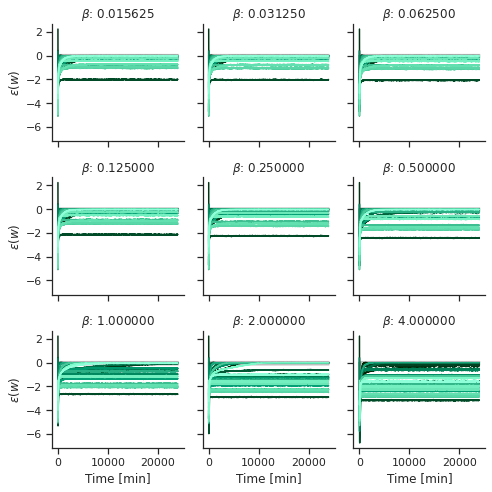

In [12]:
# Plot full training trajectories
seeds = 30
sns.set_palette(['#002100', '#002702', '#002e0c', '#003414', '#003b1b', '#004221', '#004a27', '#00512d',
                 '#005834', '#00603a', '#006841', '#006f48', '#00774f', '#007f57', '#00875e', '#008f65',
                 '#00976d', '#049f74', '#1ba77c', '#29af83', '#34b78a', '#3ebf92', '#48c799', '#51cfa1',
                 '#5ad7a9', '#63e0b0', '#6ce8b8', '#74f0c0', '#7df8c8', '#8effd8'])

lr = "0.000100"
x = np.linspace(0, datas[0]["ws"][0].shape[1]*10, datas[0]["ws"][0].shape[1])

fig, axs = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=True)
axs = axs.flatten()
for n, data in enumerate(datas):
    for i in range(seeds):
        axs[n].plot(x, dist(data["ws"][i].T, data["ws_target"][i]))
    axs[n].fill_between(x, 0.15, -0.15, color=[0.75, 0.75, 0.75])
    axs[n].set_title("$\\beta$: " + betas[n])
    #axs[n].set_ylim(-6, 1)
    if n > 5:
        axs[n].set_xlabel("Time [min]")
    if n % 3 == 0:
        axs[n].set_ylabel("$\\epsilon(w)$")
sns.despine()
fig.tight_layout()